## Compare compressed vs. raw results

In this notebook, we want to compare mutation status classification results with compressed (PCA) components as predictors against results with raw features (CpG beta values for methylation data, standardized per-gene expression values for RNA-seq data).

Notebook parameters:
* SIG_ALPHA (float): significance cutoff after FDR correction

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directories
raw_exp_results_dir = Path(cfg.results_dirs['mutation'], 'compressed_results', 'gene').resolve()
raw_27k_results_dir = Path(cfg.results_dirs['mutation'], 'bmiq_results_me_control', 'gene').resolve()
raw_450k_results_dir = Path(cfg.results_dirs['mutation'], 'vogelstein_450k_mad100k', 'gene').resolve()
compressed_results_dir = Path(cfg.results_dirs['mutation'], 'compressed_results', 'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

In [3]:
# load raw data
raw_results_df = pd.concat((
    au.load_stratified_prediction_results(raw_exp_results_dir, 'gene'),
    au.load_stratified_prediction_results(raw_27k_results_dir, 'gene'),
    au.load_stratified_prediction_results(raw_450k_results_dir, 'gene')
))

# we've only run 1 seed for raw 450K methylation data, so just use 1 seed
# for other data types, for now
raw_results_df = raw_results_df[raw_results_df.seed == 42].copy()

print(raw_results_df.shape)
print(raw_results_df.seed.unique())
print(raw_results_df.training_data.unique())
raw_results_df.head()

(7212, 9)
[42]
['expression' 'me_450k' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.74807,0.30810,MAP3K1,expression,shuffled,42,train,0,gene
1,0.55088,0.10988,MAP3K1,expression,shuffled,42,test,0,gene
2,0.52269,0.08120,MAP3K1,expression,shuffled,42,cv,0,gene
3,0.98412,0.84604,MAP3K1,expression,shuffled,42,train,1,gene
4,0.56821,0.10889,MAP3K1,expression,shuffled,42,test,1,gene


In [4]:
# load compressed data
compressed_results_df = au.load_compressed_prediction_results(compressed_results_dir, 'gene',
                                                              old_filenames=True)
compressed_results_df = compressed_results_df[compressed_results_df.seed == 42].copy()
print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
compressed_results_df.head()

(21636, 10)
[42]
['me_450k' 'expression' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.69847,0.126440,MAP3K1,me_450k,shuffled,42,train,0,1000,gene
1,0.60472,0.112250,MAP3K1,me_450k,shuffled,42,test,0,1000,gene
2,0.59254,0.093408,MAP3K1,me_450k,shuffled,42,cv,0,1000,gene
3,0.92095,0.454370,MAP3K1,me_450k,shuffled,42,train,1,1000,gene
4,0.53710,0.082582,MAP3K1,me_450k,shuffled,42,test,1,1000,gene


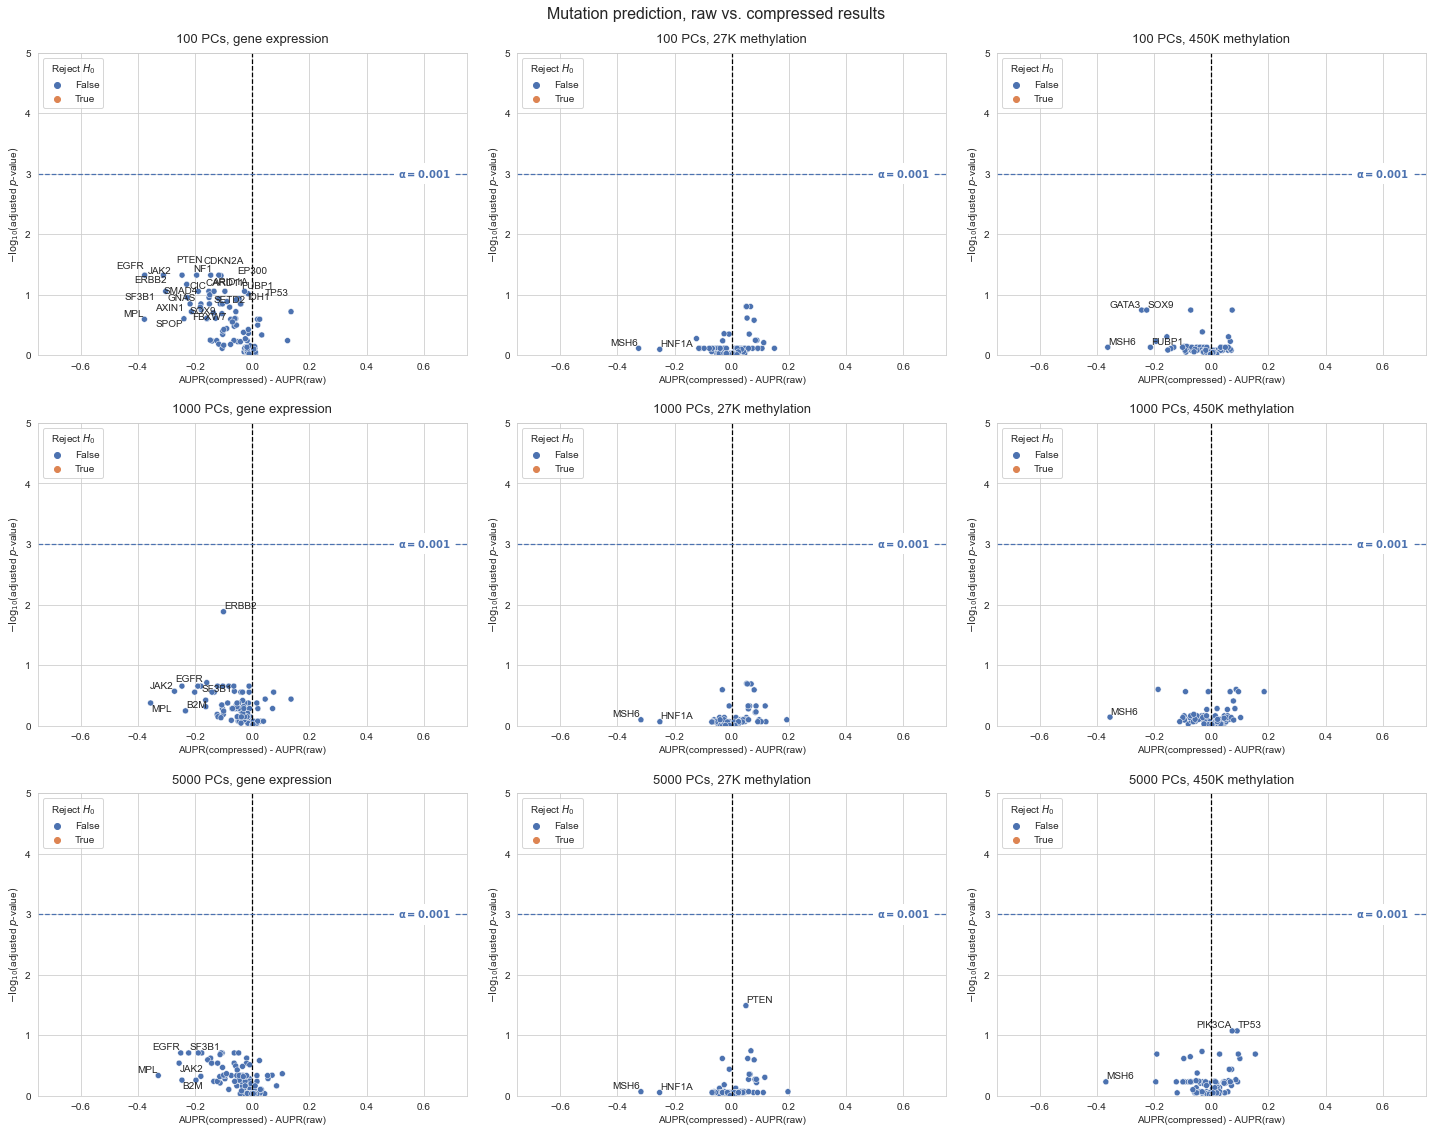

In [5]:
def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > 1.0 or abs(point['x']) > 0.2:
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot comparisons for all pairwise combinations of training datasets,
# within each choice of compression dimension
import itertools as it

sns.set({'figure.figsize': (20, 16)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(3, 3)

raw_results_df.sort_values(by=['training_data'], inplace=True)
compressed_results_df.sort_values(by=['n_dims', 'training_data'], inplace=True)
for row_ix, n_dims in enumerate(compressed_results_df.n_dims.unique()):
    for col_ix, train_data in enumerate(compressed_results_df.training_data.unique()):
        raw_data_df = raw_results_df[
            (raw_results_df.training_data == train_data)
        ]
        compressed_data_df = compressed_results_df[
            (compressed_results_df.n_dims == n_dims) &
            (compressed_results_df.training_data == train_data)
        ]
        compare_df = au.compare_results(raw_data_df,
                                        compressed_data_df,
                                        identifier='identifier',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=SIG_ALPHA,
                                        verbose=False)
        compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        compare_df['nlog10_p'] = -np.log10(compare_df.corr_pval)
        
        ax = axarr[row_ix, col_ix]
        sns.scatterplot(data=compare_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                        hue_order=[False, True], ax=ax)
        # add vertical line at 0
        ax.axvline(x=0, linestyle='--', color='black', linewidth=1.25)
        # add horizontal line at statistical significance threshold
        l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
        # label horizontal line with significance threshold
        # (matplotlib makes this fairly difficult, sadly)
        ax.text(0.6, -np.log10(SIG_ALPHA)+0.01,
                r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
                va='center', ha='center', color=l.get_color(),
                backgroundcolor=ax.get_facecolor())
        # NOTE compare_results function takes df2 - df1, so we have to invert them here
        ax.set_xlabel('AUPR(compressed) - AUPR(raw)')
        ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
        ax.set_xlim((-0.75, 0.75))
        ax.set_ylim((0, 5))
        ax.legend(title=r'Reject $H_0$', loc='upper left')
        train_names = {
            'expression': 'gene expression',
            'me_27k': '27K methylation',
            'me_450k': '450K methylation',
        }
        ax.set_title(r'{} PCs, {}'.format(n_dims, train_names[train_data]),
                     size=13, pad=10)
        

        # label genes and adjust text to not overlap
        # automatic alignment isn't perfect, can align by hand in inkscape if necessary
        text_labels = label_points(compare_df['delta_mean'],
                                   compare_df['nlog10_p'],
                                   compare_df.gene,
                                   compare_df.reject_null,
                                   ax)
        adjust_text(text_labels,
                    ax=ax, 
                    expand_text=(1., 1.),
                    lim=5)

plt.suptitle('Mutation prediction, raw vs. compressed results', size=16)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.94)

In [6]:
raw_compare_df = pd.DataFrame()
for train_data in raw_results_df.training_data.unique():
    raw_train_df = (
        raw_results_df[raw_results_df.training_data == train_data]
            .drop(columns=['training_data'])
    )
    raw_train_df.sort_values(by=['seed', 'fold'], inplace=True)
    raw_train_compare_df = au.compare_results(raw_train_df,
                                              identifier='identifier',
                                              metric='aupr',
                                              correction=True,
                                              correction_method='fdr_bh',
                                              correction_alpha=SIG_ALPHA,
                                              verbose=False)
    raw_train_compare_df['training_data'] = train_data
    raw_train_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
    raw_compare_df = pd.concat((raw_compare_df, raw_train_compare_df))
raw_compare_df.sort_values(by=['training_data', 'p_value'], inplace=True)
raw_compare_df.head(5)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data
58,KRAS,0.492977,0.000008,0.000454,True,expression
78,PTEN,0.566185,0.000013,0.000454,True,expression
4,APC,0.547465,0.000014,0.000454,True,expression
54,KDM6A,0.197953,0.000020,0.000493,True,expression
31,ERBB2,0.535942,0.000030,0.000592,True,expression


In [7]:
cmp_compare_df = pd.DataFrame()
for train_data in compressed_results_df.training_data.unique():
    for n_dims in compressed_results_df.n_dims.unique():
        cmp_train_df = (
            compressed_results_df[(compressed_results_df.training_data == train_data) &
                                  (compressed_results_df.n_dims == n_dims)]
                .drop(columns=['training_data'])
        )
        cmp_train_df.sort_values(by=['seed', 'fold'], inplace=True)
        cmp_train_compare_df = au.compare_results(cmp_train_df,
                                                  identifier='identifier',
                                                  metric='aupr',
                                                  correction=True,
                                                  correction_method='fdr_bh',
                                                  correction_alpha=SIG_ALPHA,
                                                  verbose=False)
        cmp_train_compare_df['training_data'] = train_data
        cmp_train_compare_df['n_dims'] = n_dims
        cmp_train_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        cmp_compare_df = pd.concat((cmp_compare_df, cmp_train_compare_df))
cmp_compare_df.sort_values(by=['training_data', 'n_dims', 'p_value'], inplace=True)
cmp_compare_df.head(5)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,n_dims
94,TP53,0.381740,0.000003,0.000267,True,expression,100
4,APC,0.536150,0.000026,0.000871,True,expression,100
78,PTEN,0.420255,0.000027,0.000871,True,expression,100
58,KRAS,0.439802,0.000056,0.001373,False,expression,100
48,IDH1,0.421610,0.000191,0.003290,False,expression,100


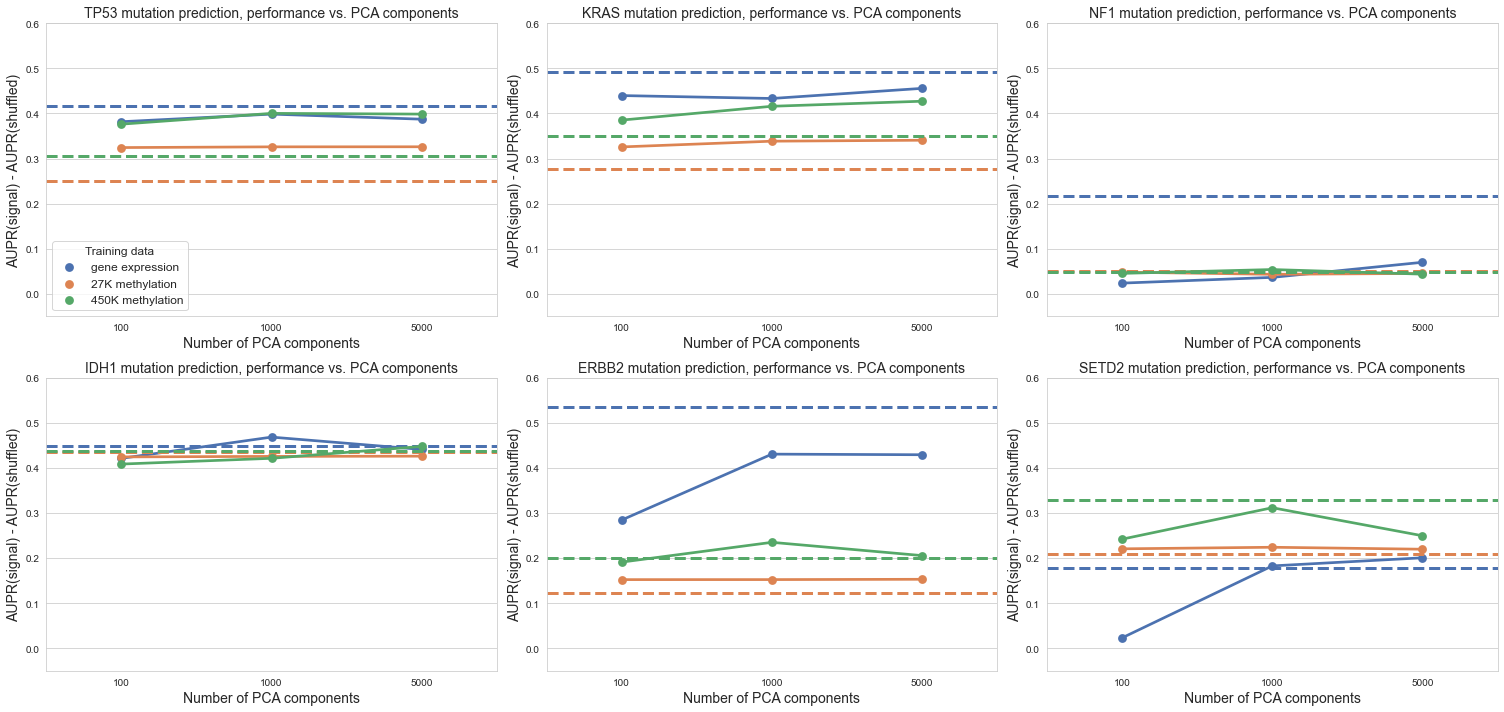

In [8]:
# look at some specific genes, we can do this using a line plot of 
# performance over increasing number of PCs
# dotted line = performance with raw features (genes/probes)
genes = ['TP53', 'KRAS', 'NF1', 'IDH1', 'ERBB2', 'SETD2']
sns.set({'figure.figsize': (21, 10)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 3)

for ix, gene in enumerate(genes):
    ax = axarr[ix // 3, ix % 3]
    cmp_gene_df = cmp_compare_df[cmp_compare_df.gene == gene].copy()
    cmp_gene_df.training_data.replace(to_replace=train_names, inplace=True)
    g = sns.pointplot(data=cmp_gene_df, x='n_dims', y='delta_mean', hue='training_data', ax=ax, legend=False)
    if ix != 0:
        ax.get_legend().remove()
    else:
        ax.legend(title='Training data', fontsize=12, title_fontsize=12,
                  loc='lower left')
    for color_ix, train_data in enumerate(raw_compare_df.training_data.unique()):
        ax.axhline(y=raw_compare_df[(raw_compare_df.gene == gene) &
                                    (raw_compare_df.training_data == train_data)].delta_mean.values[0],
                   linestyle='--', linewidth=3,
                   color=sns.color_palette()[color_ix])
    ax.set_title('{} mutation prediction, performance vs. PCA components'.format(gene), size=14)
    ax.set_xlabel('Number of PCA components', size=14)
    ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=14)
    raw_gene_df = raw_compare_df[raw_compare_df.gene == gene]
    # ax.set_ylim(-0.05, max(max(cmp_gene_df.delta_mean), max(raw_gene_df.delta_mean))+0.05)
    ax.set_ylim(-0.05, 0.6)
    
plt.tight_layout()

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_genes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_genes.png',
                dpi=300, bbox_inches='tight')

(13,)
['TP53' 'APC' 'PTEN' 'KRAS' 'ERBB2' 'ATRX' 'CDKN2A' 'IDH1' 'KDM6A'
 'PIK3CA' 'SMARCA4' 'CIC' 'BRAF']


(-0.2, 0.67232)

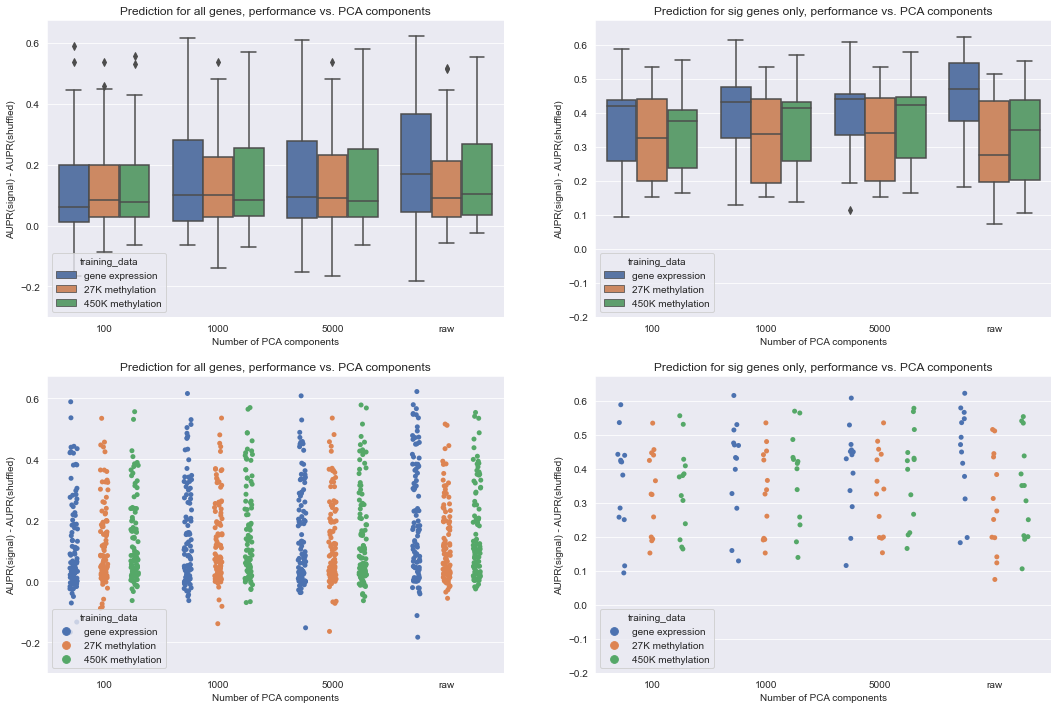

In [9]:
raw_compare_df['n_dims'] = 'raw'
compare_df = (
    pd.concat((raw_compare_df, cmp_compare_df))
      .sort_values(by=['training_data', 'n_dims'])
)
compare_df.training_data.replace(to_replace=train_names, inplace=True)

sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0, 0]
sns.boxplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', ax=ax)
ax.set_title('Prediction for all genes, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.3, max(compare_df.delta_mean + 0.05))


# plot mean performance for genes that are significant for at least one data type
ax = axarr[0, 1]
gene_list = compare_df[compare_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean', hue='training_data', ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(compare_df.delta_mean + 0.05))

ax = axarr[1, 0]
sns.stripplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', dodge=True, ax=ax)
ax.set_title('Prediction for all genes, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.3, max(compare_df.delta_mean + 0.05))

ax = axarr[1, 1]
sns.stripplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean',
              hue='training_data', dodge=True, ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(compare_df.delta_mean + 0.05))

(13,)
['TP53' 'APC' 'PTEN' 'KRAS' 'ERBB2' 'ATRX' 'CDKN2A' 'IDH1' 'KDM6A'
 'PIK3CA' 'SMARCA4' 'CIC' 'BRAF']


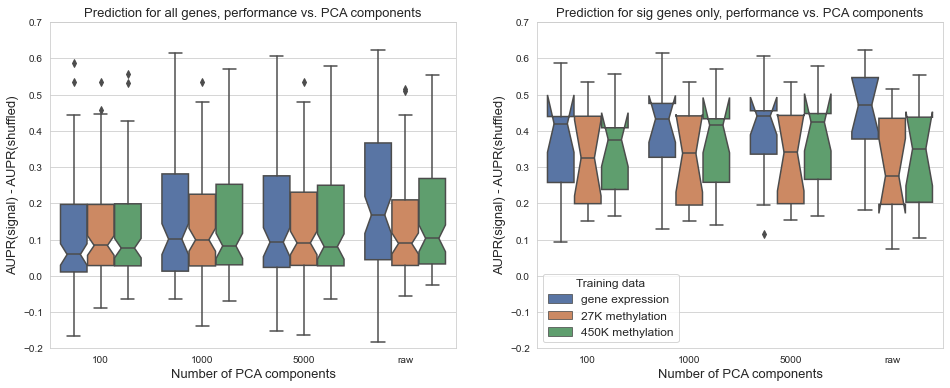

In [10]:
# same plot but only the first row (box plots)
sns.set({'figure.figsize': (16, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0]
sns.boxplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', notch=True, ax=ax)
ax.get_legend().remove()
ax.set_title('Prediction for all genes, performance vs. PCA components', size=13)
ax.set_xlabel('Number of PCA components', size=13)
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
ax.set_ylim(-0.2, 0.7)


# plot mean performance for genes that are significant for at least one data type
ax = axarr[1]
gene_list = compare_df[compare_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean',
            hue='training_data', notch=True, ax=ax)
ax.legend(title='Training data', fontsize=12, title_fontsize=12,
          loc='lower left')
ax.set_title('Prediction for sig genes only, performance vs. PCA components', size=13)
ax.set_xlabel('Number of PCA components', size=13)
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
ax.set_ylim(-0.2, 0.7)

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_compress_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_compress_boxes.png',
                dpi=300, bbox_inches='tight')

Takeaways:

* Generally, 450K methylation data seems to provide better predictive performance than 27K methylation data
* Generally, gene expression data seems to outperform 27K methylation as well
* Comparison between 450K methylation data and gene expression is less clear, but generally expression data seems to have a slight edge. Especially when filtering to significant genes, the average AUPR for the raw expression data is fairly clearly the best performer.
* We were expecting that there would be a few genes where methylation clearly outperformed expression (e.g. the IDH1 example), but that doesn't really seem to be the case. SETD1 is a possible exception, but the difference between methylation and expression isn't statistically significant (probably due to high variance in cross-validation results). On the other hand, there are a handful of genes where expression outperforms methylation clearly (e.g. ERBB2, EGFR, NF1).

Also, note that we're only currently using a single random seed here. For all the previous experiments we've run 2 replicates (2 random seeds) of 4-fold CV, so we should eventually do that here as well. The CV experiments for the raw 450k data take 3-4 days to run.